# Test on the loss function scaling in deep and shallow circuits

In [1]:
import numpy as np
import pennylane as qml
import torch as th
from tqdm import tqdm
from matplotlib import pyplot as plt

### OLD

In [2]:
def generate_H(N):
    observables = [qml.PauliZ(i) @ qml.PauliZ(i + 1) for i in range(N - 1)]

    coefficients = [1.0] * (N - 1)

    hamiltonian_sum = qml.Hamiltonian(coefficients, observables)

    h = 9 / N
    scale = 2**(N / 2)

    return h * scale * hamiltonian_sum


def calc_variance(N,L, n_sim=100):

    H = generate_H(N)

    dev = qml.device("lightning.qubit", wires=N)

    @qml.qnode(dev, interface="torch")
    def circuit(params):  
        L,N = params.shape[0:2]

        for layer in range(L):
            # Layer of rotation gates
            for i in range(N):
                qml.U3(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)

            # Layer of entangling gates
            for i in range(0, N - 1):
                qml.CNOT(wires=[i, i + 1])

        return qml.expval(H)

    result_hist = []

    for _ in range(n_sim):
        params1 = th.tensor(np.arccos(1.0 - 2 * np.random.rand(L, N)), requires_grad=True, dtype=th.float64)
        params2 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)
        params3 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)

        params = th.stack([params1, params2, params3], axis=2)

        result = circuit(params)
        result_hist.append(result)

    return result_hist


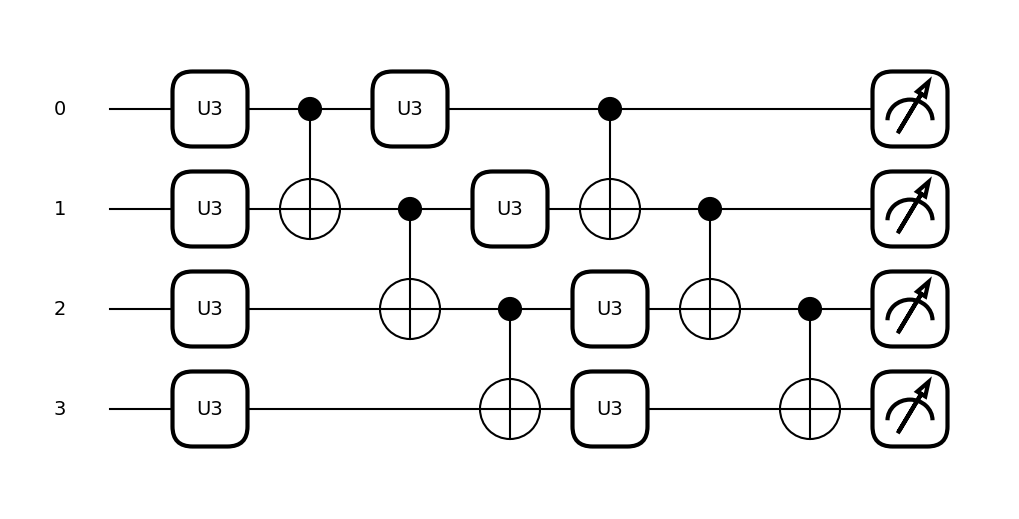

In [3]:
# Visualize the quantum circuit for given N and L using Pennylane's draw function

N = 4  # Number of qubits
L = 2  # Number of layers

dev = qml.device("lightning.qubit", wires=N)

@qml.qnode(dev, interface="torch")
def sample_circuit(params):  
    L,N = params.shape[0:2]

    for layer in range(L):
        # Layer of rotation gates
        for i in range(N):
            qml.U3(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)

        # Layer of entangling gates
        for i in range(0, N - 1):
            qml.CNOT(wires=[i, i + 1])

    return qml.expval(generate_H(N))

# Draw the circuit
params1 = th.tensor(np.arccos(1.0 - 2 * np.random.rand(L, N)), requires_grad=True, dtype=th.float64)
params2 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)
params3 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)

params = th.stack([params1, params2, params3], axis=2)
qml.draw_mpl(sample_circuit)(params)
plt.show()

In [4]:
Ns = [2, 4, 6, 8]
Ls = [2, 4, 6, 8, 10, 16]
n_sim = 50

results = {}

for N in Ns:
    results[N] = {}
    print(f"--- Starting simulations for N = {N} ---")
    for L in Ls:
        print(f"  Running for L = {L}...")
        variance = calc_variance(N, L, n_sim=n_sim)
        results[N][L] = variance

--- Starting simulations for N = 2 ---
  Running for L = 2...
  Running for L = 4...
  Running for L = 6...
  Running for L = 8...
  Running for L = 10...
  Running for L = 16...
--- Starting simulations for N = 4 ---
  Running for L = 2...


KeyboardInterrupt: 

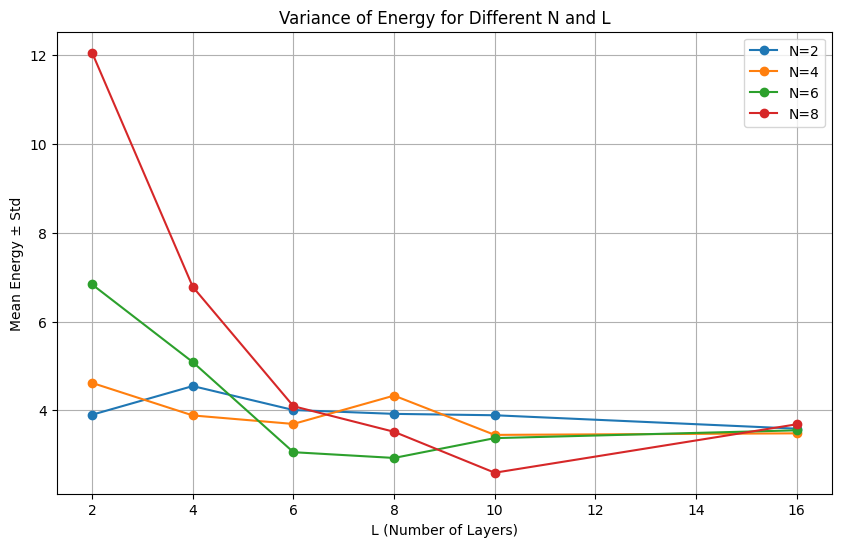

In [ ]:
# Calculate mean and standard deviation for each N and L
means = {N: [] for N in Ns}
stds = {N: [] for N in Ns}

for N in Ns:
    for L in Ls:
        vals = th.stack(results[N][L]).detach().numpy()
        means[N].append(np.mean(vals))
        stds[N].append(np.std(vals))

# Plot mean ± std for each N as a function of L
plt.figure(figsize=(10, 6))
for N in Ns:
    plt.plot(Ls, stds[N], label=f'N={N}', marker='o')

plt.xlabel('L (Number of Layers)')
plt.ylabel('Mean Energy ± Std')
plt.title('Variance of Energy for Different N and L')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import numpy as np
import pennylane as qml
import torch as th
import matplotlib.pyplot as plt
import torch.optim as optim

# ==============================================================================
# PASTE YOUR 'generate_H' and 'calc_gradient_variance' FUNCTIONS HERE
# ==============================================================================
def generate_H(N):
    # (Your function code)
    observables = [qml.PauliZ(i) @ qml.PauliZ(i + 1) for i in range(N - 1)]
    coefficients = [1.0] * (N - 1)
    hamiltonian_sum = qml.Hamiltonian(coefficients, observables)
    h = 9 / N
    scale = 2**(N / 2)
    return h * scale * hamiltonian_sum

def calc_gradient_variance(N, L, n_sim=100):
    # (The modified function from the previous answer)
    H = generate_H(N)
    dev = qml.device("lightning.qubit", wires=N)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        for layer in range(L):
            for i in range(N):
                qml.U3(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)
            for i in range(0, N - 1):
                qml.CNOT(wires=[i, i + 1])
        return qml.expval(H)
    
    partial_deriv_hist = []
    for _ in range(n_sim):
        params1 = th.tensor(np.arccos(1.0 - 2 * np.random.rand(L, N)), requires_grad=True, dtype=th.float64)
        params2 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)
        params3 = th.tensor(2 * np.pi * np.random.rand(L, N), requires_grad=True, dtype=th.float64)

        optimizer = optim.SGD([{'params': [params1, params2, params3], 'lr': 0.01}])

        params = th.stack([params1, params2, params3], axis=2)

        optimizer.zero_grad()
        
        # Forward pass
        energy = circuit(params)
        
        # Backward pass
        energy.backward()

        partial_deriv_hist.append(np.linalg.norm(params1[0,0].detach().numpy()))

    return np.var(partial_deriv_hist)
# ==============================================================================


Ns = [2, 4, 6, 8]
Ls = [2, 4, 6, 8, 10, 16]
n_sim = 50

results = {}

for N in Ns:
    results[N] = {}
    print(f"--- Starting simulations for N = {N} ---")
    for L in Ls:
        print(f"  Running for L = {L}...")
        variance = calc_gradient_variance(N, L, n_sim=n_sim)
        results[N][L] = variance

--- Starting simulations for N = 2 ---
  Running for L = 2...
  Running for L = 4...
  Running for L = 6...
  Running for L = 8...
  Running for L = 10...
  Running for L = 16...
--- Starting simulations for N = 4 ---
  Running for L = 2...
  Running for L = 4...
  Running for L = 6...
  Running for L = 8...
  Running for L = 10...
  Running for L = 16...
--- Starting simulations for N = 6 ---
  Running for L = 2...
  Running for L = 4...
  Running for L = 6...
  Running for L = 8...
  Running for L = 10...
  Running for L = 16...
--- Starting simulations for N = 8 ---
  Running for L = 2...
  Running for L = 4...
  Running for L = 6...
  Running for L = 8...
  Running for L = 10...
  Running for L = 16...


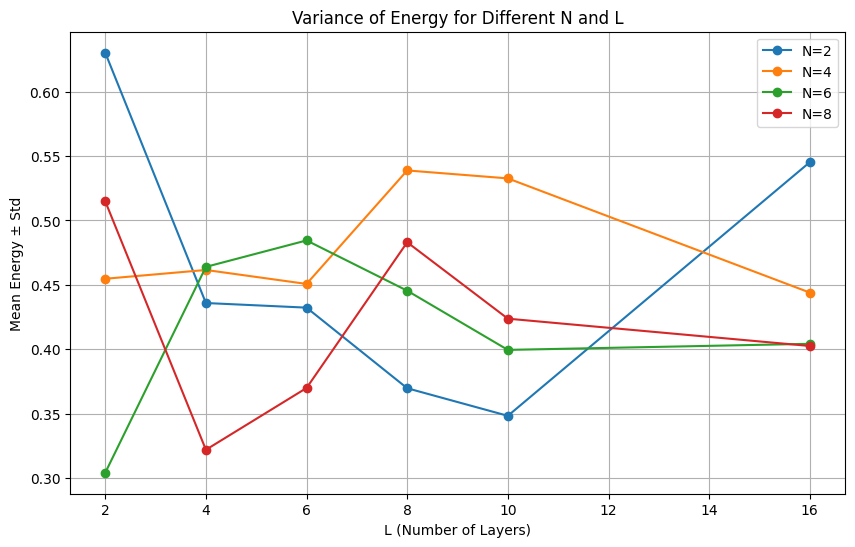

In [28]:
# Calculate mean and standard deviation for each N and L
stds = {N: [] for N in Ns}

for N in Ns:
    for L in Ls:
        stds[N].append(results[N][L])

# Plot mean ± std for each N as a function of L
plt.figure(figsize=(10, 6))
for N in Ns:
    plt.plot(Ls, stds[N], label=f'N={N}', marker='o')

plt.xlabel('L (Number of Layers)')
plt.ylabel('Mean Energy ± Std')
plt.title('Variance of Energy for Different N and L')
plt.legend()
plt.grid(True)
plt.show()